This tutorial summarizes the tools to predict the LIM outcomes of Zeus21.

In [2]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

Set up the cosmology, astrophysics and the line parameters.

In [3]:
#plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [4]:
#set up your parameters here, as an example the CDM (reduced) density
omega_cdm = 0.12
CosmoParams_input = zeus21.Cosmo_Parameters_Input(omegac = omega_cdm)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
print('CLASS has run, we store the cosmology.')

CLASS has run, we store the cosmology.


In [5]:
LineParams_input = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 0.5,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4,
                 CII_alpha_SFR_z = -0.07,
                 CII_beta_SFR_0 = 7.1,
                 CII_beta_SFR_z = -0.07,
                 CII_sigma_LSFR = 0.5)

LineParams_input_1 = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 3., # for now we consider radius larger than NL level 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.5)

LineParams_input_50 = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 50., # for now we consider radius larger than NL level 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.5)

In [6]:
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
HMFintclass = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
print('HMF interpolator built. This ends the cosmology part -- moving to astrophysics.')

LineParams = zeus21.Line_Parameters(LineParams_input) 
LineParams_1 = zeus21.Line_Parameters(LineParams_input_1) 
LineParams_50 = zeus21.Line_Parameters(LineParams_input_50) 
CorrFClass = zeus21.Correlations_LIM(LineParams, CosmoParams, ClassyCosmo)
CorrFClass_1 = zeus21.Correlations_LIM(LineParams_1, CosmoParams, ClassyCosmo)
CorrFClass_50 = zeus21.Correlations_LIM(LineParams_50, CosmoParams, ClassyCosmo)
print('Correlation functions saved.')

#set up your astro parameters too, here the peak of f*(Mh) as an example
AstroParams = zeus21.Astro_Parameters(CosmoParams)

ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
CoeffStructure = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams, zmin=ZMIN)
CoeffStructure_1 = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams_1, zmin=ZMIN)
CoeffStructure_50 = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams_50, zmin=ZMIN)

zlist = CoeffStructure.zintegral
print('LIM and coefficients stored. Move ahead.')

HMF interpolator built. This ends the cosmology part -- moving to astrophysics.
Your resolution introduces too large non linear corrections on small scales! 
We use instead MIN_R_NONLINEAR = 2 Mpc
Correlation functions saved.


/home/sarah/anaconda3/envs/zeus21/lib/python3.9/site-packages/zeus21/LIM.py:283: RuntimeWarning: divide by zero encountered in log10
  log10_L = alpha_SFR * np.log10(SFR) + beta_SFR
/home/sarah/anaconda3/envs/zeus21/lib/python3.9/site-packages/zeus21/LIM.py:295: RuntimeWarning: invalid value encountered in log
  lognormal_nan = lambda meanLSFR: (1/(np.sqrt(2*np.pi)*sigma*Lval(meanLSFR)))*np.exp(- (np.log(Lval(meanLSFR))-mu(meanLSFR))/(2*sigma**2))
/home/sarah/anaconda3/envs/zeus21/lib/python3.9/site-packages/zeus21/LIM.py:291: RuntimeWarning: divide by zero encountered in log
  mu = lambda meanLSFR: np.log(meanLSFR) - (sigma**2)/2


LIM and coefficients stored. Move ahead.


The standard Zeus21 consider the $\rm SFRD$ from Gallumi and it introduces a deterministic relation between this quantity and $M_h$, such that 

${\rm SFRD} [M_\odot/{\rm yr }/{\rm Mpc}^3] = \int_{M_h^{\rm min}}^{M_h^{\rm max}}d\log_{10}M_h M_h\frac{dn}{dM_h}{\rm SFR}(M_h)$

Text(0, 0.5, '$\\rm SFRD [M_\\odot/{\\rm yr}/{\\rm Mpc}^3]$')

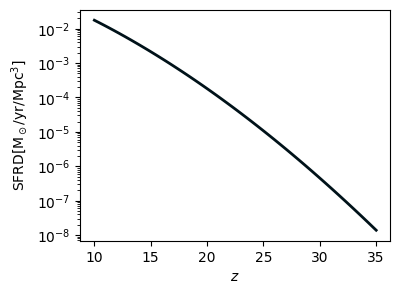

In [7]:
plt.figure(figsize=(4,3))
plt.semilogy(CoeffStructure_21.zGreaterMatrix[:,0],CoeffStructure_21.SFRDbar2D_II[:,0])#,label=r'$R=%g\,{\rm Mpc}$'%CoeffStructure_21.Rtabsmoo[0])
#plt.semilogy(CoeffStructure_21.zGreaterMatrix[:,-10],CoeffStructure_21.SFRDbar2D_II[:,-10],label=r'$R=%g\,{\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[-10],0))
#plt.legend(loc=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$\rm SFRD [M_\odot/{\rm yr}/{\rm Mpc}^3]$')

First of all, we consider the relation between the luminosity of the CII line and the SFR, as modelled by Lagache et al. (2018) https://www.aanda.org/articles/aa/pdf/2018/01/aa32019-17.pdf. 
Such relation is defiend as follows.

$\log_{10} \dfrac{L}{L_\odot} = \alpha_{\rm SFR}\log_{10}\dfrac{\rm SFR}{M_\odot/{\rm yr}}+\beta_{\rm SFR}$

$\alpha_{\rm SFR} = 1.4 - 0.07z $

$\beta_{\rm SFR} = 7.1-0.07z$

The first issue we face is that above $z=20$ the $\alpha_{\rm SFR}$ coefficient becomes negative, implying that the luminosity would get larger for smaller, less star forming halos. To overcome this issue, for the moment we set ${\rm min}(\alpha_{\rm SFR}) = 0$, which implies that for $z \geq 20$ the line luminosity is constant with $M_h$ (and with the $\rm SFR$).

Moreover, we consider the case where the parameters $\alpha_{\rm SFR} = 1.4 -0.07\times 10 = 0.7$ and $\beta_{\rm SFR} = 7.1-0.07\times 10 = 6.4$ are constant in $z$ (dashed lines, case [1] in the following plots).

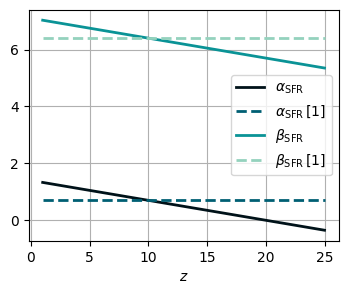

In [8]:
z_test_LIM = np.linspace(1.,25.)

alpha_SFR = lambda z: LineParams.CII_alpha_SFR_0 + LineParams.CII_alpha_SFR_z*z
beta_SFR = lambda z: LineParams.CII_beta_SFR_0 + LineParams.CII_beta_SFR_z*z

alpha_SFR_1 = lambda z: LineParams_1.CII_alpha_SFR_0 + LineParams_1.CII_alpha_SFR_z*z
beta_SFR_1 = lambda z: LineParams_1.CII_beta_SFR_0 + LineParams_1.CII_beta_SFR_z*z

plt.figure(figsize=(4,3))
plt.plot(z_test_LIM,alpha_SFR(z_test_LIM),label=r'$\alpha_{\rm SFR}$')
plt.plot(z_test_LIM,alpha_SFR_1(z_test_LIM),'--',label=r'$\alpha_{\rm SFR}\,[1]$')
plt.plot(z_test_LIM,beta_SFR(z_test_LIM),label=r'$\beta_{\rm SFR}$')
plt.plot(z_test_LIM,beta_SFR_1(z_test_LIM),'--',label=r'$\beta_{\rm SFR}\,[1]$')
plt.xlabel(r'$z$')
plt.legend()
plt.grid()


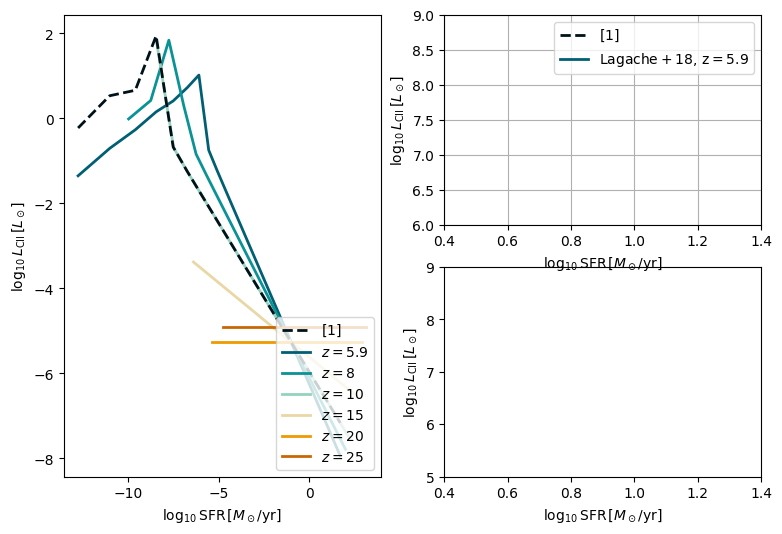

In [9]:
massVector = np.logspace(7,12)
z = [5.9,8.,10.,15.,20.,25.]
plt.figure(figsize=(9,6))
for i in z:
    SFR = LIM.dot_Mstar(AstroParams, CosmoParams, HMFintclass, massVector, z = i)
    LCII = LIM.LineLuminosity(LineParams, AstroParams, CosmoParams, HMFintclass, massVector, z = i)
    LCII_1 = LIM.LineLuminosity(LineParams_1, AstroParams, CosmoParams, HMFintclass, massVector, z = i)

    plt.subplot(121)
    if i == 5.9:
        plt.plot(np.log10(SFR),np.log10(LCII_1),'--',label=r'$[1]$')
    plt.plot(np.log10(SFR),np.log10(LCII),label=r'$z=%g$'%i,zorder=1)
    plt.xlabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
    plt.ylabel(r'$\log_{10} L_{\rm CII}\,[L_\odot]$')
    plt.legend(loc=4)
    
    plt.subplot(224)
    if i == 5.9:
        plt.plot(np.log10(SFR),np.log10(LCII_1),'--',label=r'$[1]$')
    plt.plot(np.log10(SFR),np.log10(LCII),label=r'$z=%g$'%i,zorder=1)
    plt.xlabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
    plt.ylabel(r'$\log_{10} L_{\rm CII}\,[L_\odot]$')
    plt.xlim(0.4,1.4)
    plt.ylim(5,9)
    
    if i == 5.9:
        plt.subplot(222)
        plt.plot(np.log10(SFR),np.log10(LCII_1),'--',label=r'$\rm [1]$')
        plt.plot(np.log10(SFR),np.log10(LCII),label=r'$\rm Lagache+18,\,z=%g$'%i)
        plt.legend()
        plt.xlabel(r'$\log_{10}{\rm SFR}\,[M_\odot/{\rm yr}]$')
        plt.ylabel(r'$\log_{10} L_{\rm CII}\,[L_\odot]$')
        plt.xlim(0.4,1.4)
        plt.ylim(6,9)
        plt.grid()

We then model the average luminosity density, as 

$\rho_L [L_\odot/{\rm Mpc}^3] = \int_{M_h^{\rm min}}^{M_h^{\rm max}} d\log_{10}M_h M_h\dfrac{dn}{dM_h}L({\rm SFR}(M_h))$    

where the array that we create has dimension $N_z \times 1$, in analogy to the $\rm SFRD$ case of the standard Zeus21, which has size $N_z\times N_{R}$, being $R$ the array of smoothing scales used in the peak background split.

In the Lagache case, we obtain a line luminosity that peaks around $z=20$, which is due to the fact that at higher $z$ the fainter galaxies have a larger $L({\rm SFR})$ and are still luminous.

In our modified case, instead, the luminosity simply decreases in $z$ (which seems more reasonable), hence we proceed in our analysis only with this case.

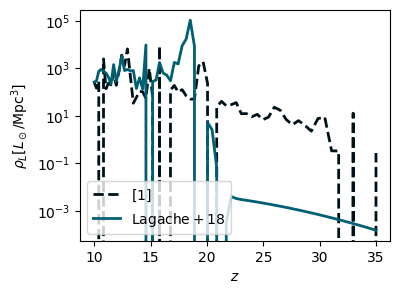

In [10]:
plt.figure(figsize=(4,3))
plt.semilogy(CoeffStructure_1.zGreaterMatrix,CoeffStructure_1.rhoLbar,'--',label=r'$[1]$')
plt.semilogy(CoeffStructure.zGreaterMatrix,CoeffStructure.rhoLbar, label=r'$\rm Lagache+18$')
plt.xlabel(r'$z$')
plt.ylabel(r'$\rho_L [L_\odot/{\rm Mpc}^3]$')
plt.legend(loc=3)

In the original Zeus21, they write

${\rm SFRD}(x,R) = (1+\delta_R)\int dM_h \frac{dn}{dM_h}(\delta_R)\dot{M}_* \sim \bar{\rm SFRD}e^{\gamma_R\tilde{\delta_R}}$

while in our case a similar relation holds for $\rho_L(x,R_0)$. To verify that the lognormal approximation is good, we can reproduce Fig. 3 in Zeus21 paper (1) and Fig. 5 in Zeus21 paper (2). In particular, we consider 

Linear approximation (for the two point function): 
$\exp((\gamma_R \delta_R)^2) \sim 1+(\gamma\delta^2)$

Non linear correction: 
$\exp((\gamma_R \delta_R)^2) - (1+(\gamma\delta)^2)$

Non linear correction relevance: 
$(\exp((\gamma_R \delta_R)^2) - (1+(\gamma\delta)^2))/(\gamma\delta)^2 = (\exp((\gamma_R \delta_R)^2) - 1)/(\gamma\delta)^2 -1 $

/tmp/ipykernel_18576/2784815439.py:62: RuntimeWarning: invalid value encountered in divide
  nl_bias = (np.exp(lin_bias**2)-1)/lin_bias**2 -1


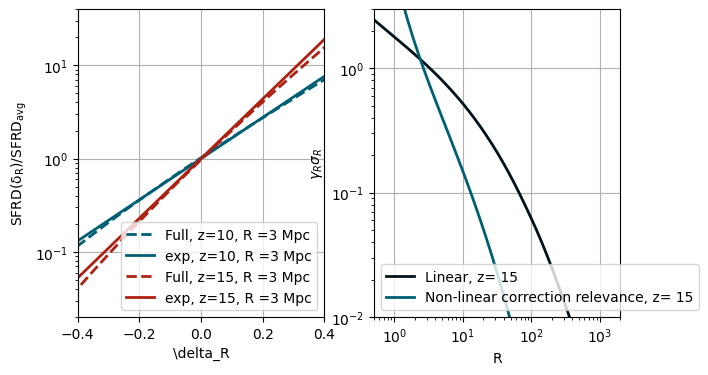

In [11]:
bar_SFRD = CoeffStructure_21.SFRDbar2D_II

Nsigmad = 5.0 #how many sigmas we explore
Nds = 100 #how many deltas
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)
zArray, rArray, mArray, deltaNormArray = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)

rGreaterArray = np.zeros_like(zArray) + rArray

rGreaterArray[CosmoParams.chiofzint(zArray) + rArray >= CosmoParams.chiofzint(50)] = np.nan
zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray) + rGreaterArray)
sigmaR = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), 1, 1))
whereNotNans = np.invert(np.isnan(rGreaterArray))
sigmaR[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans]))

zid = 0
zid1 = 21
Rid = 10
deltaArray = deltaNormArray * sigmaR
SFRD_deltaR =  np.exp(CoeffStructure_21.gamma_II_index2D [zid,Rid]* deltaArray[zid,Rid,0,:]) #* bar_SFRD[zid,Rid]

SFRD_deltaR1 =  np.exp(CoeffStructure_21.gamma_II_index2D [zid1,Rid]* deltaArray[zid1,Rid,0,:])  #* bar_SFRD[zid1,Rid]

sigmaM = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), len(HMFintclass.Mhtab), 1)) ###HAC: Is this necessary?
sigmaM = HMFintclass.sigmaintlog((np.log(mArray), zGreaterArray))

modSigmaSq = sigmaM**2 - sigmaR**2
indexTooBig = (modSigmaSq <= 0.0)
modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
modSigma = np.sqrt(modSigmaSq)

nu0 = CosmoParams.delta_crit_ST / sigmaM
nu0[indexTooBig] = 1.0
modd = CosmoParams.delta_crit_ST - deltaArray
nu = modd / modSigma
C_arb = 1.6
EPS_HMF_corr = C_arb * (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)
integrand_II = EPS_HMF_corr * zeus21.sfrd.SFRD_II_integrand(AstroParams, CosmoParams, HMFintclass, mArray, zGreaterArray, zGreaterArray)


SFRD_II_dR = np.trapz(integrand_II, HMFintclass.logtabMh, axis = 2)[zid,Rid] / bar_SFRD[zid,Rid]
SFRD_II_dR1 = np.trapz(integrand_II, HMFintclass.logtabMh, axis = 2)[zid1,Rid] /bar_SFRD[zid1,Rid]

plt.figure(figsize=(7,4))
plt.subplot(121)

plt.semilogy(deltaArray[zid,Rid,0,:],SFRD_II_dR,label=r'Full, z=%g'%round(CoeffStructure_21.zintegral[zid],0) + r', R =%g Mpc'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[1],linestyle='--')
plt.semilogy(deltaArray[zid,Rid,0,:],SFRD_deltaR,label=r'exp, z=%g'%round(CoeffStructure_21.zintegral[zid],0) + r', R =%g Mpc'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[1])

plt.semilogy(deltaArray[zid1,Rid,0,:],SFRD_II_dR1,label=r'Full, z=%g'%round(CoeffStructure_21.zintegral[zid1],0) + r', R =%g Mpc'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[-2],linestyle='--')

plt.semilogy(deltaArray[zid1,Rid,0,:],SFRD_deltaR1,label=r'exp, z=%g'%round(CoeffStructure_21.zintegral[zid1],0) + r', R =%g Mpc'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[-2])
plt.legend()
plt.ylabel(r'$\rm SFRD(\delta_R)/SFRD_{avg}$')
plt.xlabel('\delta_R')
plt.ylim(2e-2,4e1)
plt.xlim(-0.4,0.4)
plt.grid()

lin_bias = CoeffStructure_21.gamma_II_index2D[zid1,:] * (sigmaR[zid1,:,0,0])

nl_bias = (np.exp(lin_bias**2)-1)/lin_bias**2 -1

plt.subplot(122)
plt.loglog(CoeffStructure_21.Rtabsmoo,lin_bias,label='Linear, z= %g'%round(CoeffStructure_21.zintegral[zid1],0) )
plt.loglog(CoeffStructure_21.Rtabsmoo,nl_bias,label='Non-linear correction relevance, z= %g'%round(CoeffStructure_21.zintegral[zid1],0))
plt.legend()
plt.ylabel(r'$\gamma_R \sigma_R$')
plt.xlabel('R')
plt.ylim(1e-2,3)
plt.xlim(5e-1,2e3)
plt.grid()


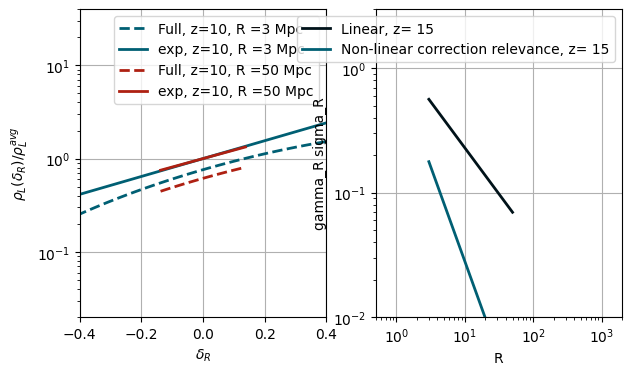

In [12]:
bar_rhoL = CoeffStructure_1.rhoLbar
bar_rhoL_50 = CoeffStructure_50.rhoLbar

Nsigmad = 5.0 #how many sigmas we explore
Nds = 100 #how many deltas
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)
zArray_LIM, rArray_LIM, mArray_LIM, deltaNormArray_LIM = np.meshgrid(CoeffStructure_1.zintegral, CoeffStructure_1.Rtabsmoo_LIM, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)
zArray_LIM_50, rArray_LIM_50, mArray_LIM_50, deltaNormArray_LIM_50 = np.meshgrid(CoeffStructure_50.zintegral, CoeffStructure_50.Rtabsmoo_LIM, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)

rGreaterArray = np.zeros_like(zArray_LIM) + rArray_LIM
rGreaterArray_50 = np.zeros_like(zArray_LIM_50) + rArray_LIM_50


rGreaterArray[CosmoParams.chiofzint(zArray_LIM) + rArray_LIM >= CosmoParams.chiofzint(50)] = np.nan
zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray_LIM) + rGreaterArray) 

rGreaterArray_50[CosmoParams.chiofzint(zArray_LIM_50) + rArray_LIM_50 >= CosmoParams.chiofzint(50)] = np.nan
zGreaterArray_50 = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray_LIM_50) + rGreaterArray_50) 

whereNotNans = np.invert(np.isnan(rGreaterArray))
sigmaR_LIM = np.zeros((len(CoeffStructure_1.zintegral), 1, 1, 1)) 
sigmaR_LIM[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans])) 

sigmaR_LIM_50 = np.zeros((len(CoeffStructure_50.zintegral), 1, 1, 1)) 
sigmaR_LIM_50[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray_50)[whereNotNans], zGreaterArray_50[whereNotNans])) 

deltaArray_LIM = deltaNormArray_LIM * sigmaR_LIM
rhoL_deltaR =  np.exp(CoeffStructure_1.gammaLIM_index [zid,0]* deltaArray_LIM[zid,0,0,:]) #* bar_rhoL[zid,0]
deltaArray_LIM_50 = deltaNormArray_LIM_50 * sigmaR_LIM_50
rhoL_deltaR_50 =  np.exp(CoeffStructure_50.gammaLIM_index [zid,0]* deltaArray_LIM_50[zid,0,0,:]) #* bar_rhoL_50[zid,0]

sigmaM_LIM = np.zeros((len(CoeffStructure_1.zintegral), 1, len(HMFintclass.Mhtab), 1)) 
sigmaM_LIM = HMFintclass.sigmaintlog((np.log(mArray_LIM), zGreaterArray)) 
sigmaM_LIM_50 = np.zeros((len(CoeffStructure_50.zintegral), 1, len(HMFintclass.Mhtab), 1)) 
sigmaM_LIM_50 = HMFintclass.sigmaintlog((np.log(mArray_LIM_50), zGreaterArray_50)) 

modSigmaSq_LIM = sigmaM_LIM**2 - sigmaR_LIM**2
modSigmaSq_LIM_50 = sigmaM_LIM_50**2 - sigmaR_LIM_50**2
indexTooBig_LIM = (modSigmaSq_LIM <= 0.0)
modSigmaSq_LIM[indexTooBig_LIM] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R._LIM Cut the sum
modSigma_LIM = np.sqrt(modSigmaSq_LIM)
indexTooBig_LIM_50 = (modSigmaSq_LIM_50 <= 0.0)
modSigmaSq_LIM_50[indexTooBig_LIM_50] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
modSigma_LIM_50 = np.sqrt(modSigmaSq_LIM_50)

nu0_LIM = CosmoParams.delta_crit_ST / sigmaM_LIM
nu0_LIM[indexTooBig_LIM] = 1.0
modd_LIM = CosmoParams.delta_crit_ST - deltaArray_LIM
nu_LIM = modd_LIM / modSigma_LIM
C_arb_LIM = 1.3
EPS_HMF_corr_LIM = C_arb_LIM * (nu_LIM/nu0_LIM) * (sigmaM_LIM/modSigma_LIM)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu_LIM**2-nu0_LIM**2)/2.0 ) * (1.0 + deltaArray_LIM)
integrand_LIM= EPS_HMF_corr_LIM * zeus21.LIM.rhoL_integrand(LineParams_1, AstroParams, CosmoParams, HMFintclass, mArray_LIM, zGreaterArray)

nu0_LIM_50 = CosmoParams.delta_crit_ST / sigmaM_LIM_50
nu0_LIM_50[indexTooBig_LIM_50] = 1.0
modd_LIM_50 = CosmoParams.delta_crit_ST - deltaArray_LIM_50
nu_LIM_50 = modd_LIM_50 / modSigma_LIM_50
C_arb_LIM_50 = 1.
EPS_HMF_corr_LIM_50 = C_arb_LIM_50 * (nu_LIM_50/nu0_LIM_50) * (sigmaM_LIM_50/modSigma_LIM_50)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu_LIM_50**2-nu0_LIM_50**2)/2.0 ) * (1.0 + deltaArray_LIM_50)
integrand_LIM_50= EPS_HMF_corr_LIM_50 * zeus21.LIM.rhoL_integrand(LineParams_50, AstroParams, CosmoParams, HMFintclass, mArray_LIM_50, zGreaterArray)


rhoL_dR = np.trapz(integrand_LIM, HMFintclass.logtabMh, axis = 2)[zid,0] / bar_rhoL[zid,0]
rhoL_dR_50 = np.trapz(integrand_LIM_50, HMFintclass.logtabMh, axis = 2)[zid,0] / bar_rhoL_50[zid,0]

plt.figure(figsize=(7,4))
plt.subplot(121)
plt.semilogy(deltaArray_LIM[zid,0,0,:],rhoL_dR,label=r'Full, z=%g'%round(CoeffStructure_1.zintegral[zid],0) + r', R =%g Mpc'%round(LineParams_1._R,0),color=colors[1],linestyle='--')
plt.semilogy(deltaArray_LIM[zid,0,0,:],rhoL_deltaR,label=r'exp, z=%g'%round(CoeffStructure_1.zintegral[zid],0) + r', R =%g Mpc'%round(LineParams_1._R,0),color=colors[1])

plt.semilogy(deltaArray_LIM_50[zid,0,0,:],rhoL_dR_50,label=r'Full, z=%g'%round(CoeffStructure_50.zintegral[zid],0) + r', R =%g Mpc'%round(LineParams_50._R,0),color=colors[-2],linestyle='--')
plt.semilogy(deltaArray_LIM_50[zid,0,0,:],rhoL_deltaR_50,label=r'exp, z=%g'%round(CoeffStructure_50.zintegral[zid],0) + r', R =%g Mpc'%round(LineParams_50._R,0),color=colors[-2])
plt.legend()
plt.ylabel(r'$\rho_L(\delta_R)/\rho_L^{avg}$')
plt.xlabel(r'$\delta_R$')
plt.ylim(2e-2,4e1)
plt.xlim(-0.4,0.4)
plt.grid()

lin_bias_LIM = CoeffStructure_1.gammaLIM_index[zid1,0] * (sigmaR_LIM[zid1,0,0,0])
nl_bias_LIM = (np.exp(lin_bias_LIM**2)-1)/lin_bias_LIM**2 -1
lin_bias_LIM_50 = CoeffStructure_50.gammaLIM_index[zid1,0] * (sigmaR_LIM_50[zid1,0,0,0])
nl_bias_LIM_50 = (np.exp(lin_bias_LIM_50**2)-1)/lin_bias_LIM_50**2 -1


plt.subplot(122)
plt.loglog([LineParams_1._R,LineParams_50._R],[lin_bias_LIM,lin_bias_LIM_50],label='Linear, z= %g'%round(CoeffStructure_1.zintegral[zid1],0) )
plt.loglog([LineParams_1._R,LineParams_50._R],[nl_bias_LIM,nl_bias_LIM_50],label='Non-linear correction relevance, z= %g'%round(CoeffStructure_21.zintegral[zid1],0))
plt.legend()
plt.ylabel('gamma_R sigma_R')
plt.xlabel('R')
plt.ylim(1e-2,3)
plt.xlim(5e-1,2e3)
plt.grid()


The next step is to model the average intensity/brightness temperature measured in the survey, as 

$\bar{I}_\nu [L_\odot {\rm/cm^2/sr/Hz}] \,= \dfrac{c}{4\pi H(z)\nu_{\rm rest}}{\rho}_L(z)$

$\qquad \quad\qquad \bar{T}_\nu [\mu K] = \dfrac{c^3(1+z^2)}{8\pi k_B H(z)\nu_{\rm rest}^3}{\rho}_L(z)$

$\qquad\qquad\qquad\qquad\,\, = c_1^{\rm LIM}(z)c_2^{\rm LIM}(z)$

Note that, differently from the standard Zeus21 case, both the coefficients only depend on $z$ and not on $R$. We continue using $\bar{T}_\nu$.

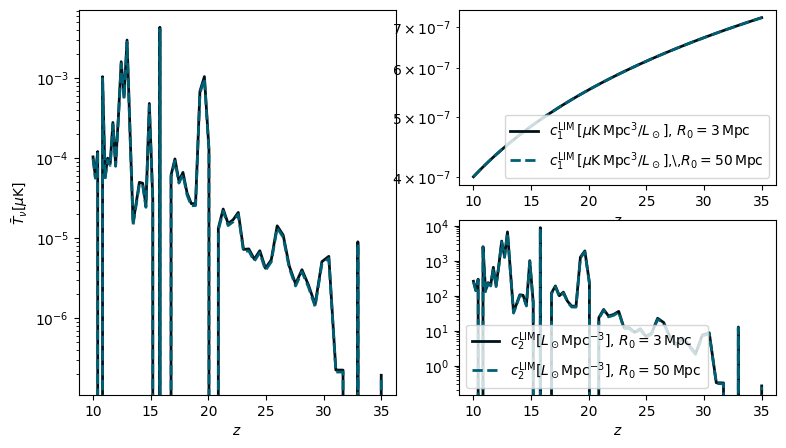

In [13]:
plt.figure(figsize=(9,5))
plt.subplot(121)
plt.semilogy(zlist,CoeffStructure_1.Inu_avg, label = r'$R_0 = %g\,{\rm Mpc}$'%LineParams._R)
plt.semilogy(zlist,CoeffStructure_50.Inu_avg, '--',label = r'$R_0 = %g\,{\rm Mpc}$'%LineParams_50._R)
plt.xlabel(r'$z$')
plt.ylabel(r'$\bar{T}_{\nu} [\mu {\rm K}]$')

plt.subplot(222)
plt.semilogy(zlist,CoeffStructure_1.coeff1_LIM,label=r'$c_1^{\rm LIM}\,[\mu {\rm K\,Mpc^3}/L_\odot],\,$' + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_1._R)
plt.semilogy(zlist,CoeffStructure_50.coeff1_LIM,'--',label=r'$c_1^{\rm LIM}\,[\mu {\rm K\,Mpc^3}/L_\odot]$,\,' + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_50._R)
plt.xlabel(r'$z$')
plt.legend()

plt.subplot(224)
plt.semilogy(zlist,CoeffStructure_1.coeff2_LIM,label=r'$c_2^{\rm LIM} [L_\odot{\rm Mpc^{-3}}],\,$' + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_1._R)
plt.semilogy(zlist,CoeffStructure_50.coeff2_LIM,'--',label=r'$c_2^{\rm LIM} [L_\odot{\rm Mpc^{-3}}],\,$'  + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_50._R)
plt.xlabel(r'$z$')
plt.legend(loc=3)

In [14]:
print('bar_T =' + str(CoeffStructure_1.Inu_avg[0]))

bar_T =0.00010370689752175585


We now proceed to compute the LIM auto-correlation and power spectrum. 

First of all, we define the tophat window function $W(k,R_0)$, where $R_0$ is the $\_R$ resolution value that we plugged in the Line Parameters. We here compare two cases, $R_0 = 50 {\rm Mpc}$ and $R_0 = 3 {\rm Mpc}$ (which is the one that then we use in the main analysis), where all the other line parameters are the same.

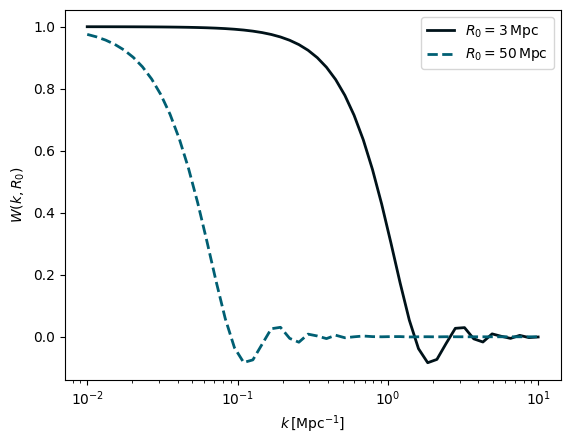

In [15]:
k = np.logspace(-2,1)
W_3 = CorrFClass_1.Window(k,LineParams_1._R)
W_50 = CorrFClass_50.Window(k,LineParams_50._R)

plt.semilogx(k,W_3,label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_1._R)
plt.semilogx(k,W_50,'--',label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_50._R)
plt.xlabel(r'$k\,[{\rm Mpc}^{-1}]$')
plt.ylabel(r'$W(k,R_0)$')
plt.legend()

And we then compute the linear matter correlation function smoothed over these windows, namely

$\xi(r) = {\rm FT}[P(k)W_{R_0}(k)^2]$

This array has size $N_{R_S} \times N_{R_S} \times N_k = 1 \times 1 \times N_z$.

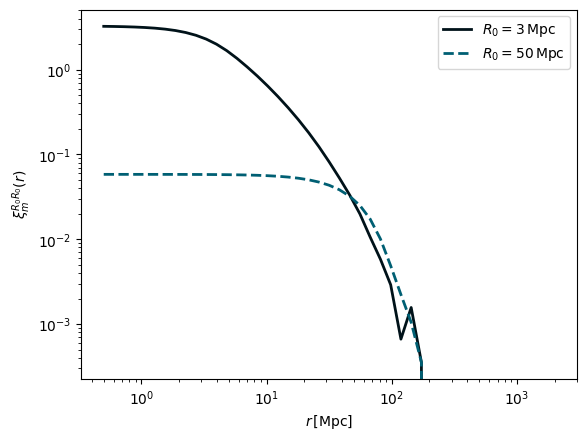

In [16]:
xi_3 = CorrFClass_1.xi_LIMLIM_CF
xi_50 = CorrFClass_50.xi_LIMLIM_CF

plt.loglog(CorrFClass_1.rlist_CF,xi_3[0,0,:],label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_1._R)
plt.loglog(CorrFClass_50.rlist_CF,xi_50[0,0,:],'--',label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_50._R)
plt.xlabel(r'$r\,[{\rm Mpc}]$')
plt.ylabel(r'$\xi_m^{R_0R_0}(r)$')
plt.legend()

We now study the Power Spectrum module.

In [17]:
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PSLIM = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams, LineParams_1, CorrFClass_1, 'here we will put 21cm coeffs', CoeffStructure_1, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

Computed the LIM power spectrum.


In [18]:
PSLIM_50 = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams,LineParams_50, CorrFClass_50, 'here we will put 21cm coeffs', CoeffStructure_50, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

Computed the LIM power spectrum.


To compare, we also extract the 21cm power spectrum.

In [19]:
CorrFClass_21 = zeus21.Correlations(CosmoParams, ClassyCosmo)
PS21 = zeus21.Power_Spectra(CosmoParams, AstroParams, ClassyCosmo, CorrFClass_21, CoeffStructure_21, RSD_MODE = RSDMODE)
print('Computed the 21cm power spectrum.')

Computed the 21cm power spectrum.


The module computes the window $c_1^{\rm LIM}c_2^{\rm LIM}\gamma_{R_0}^{\rm LIM}D(z)$, which has size $N_z\times 1$ and it is then squared and applied to the power spectrum. 

Note that in the 21cm original code such window was $R$ dependent, hence it was transformed as
$ \tilde{W}^{\rm 21cm}_{R}(z,k) = {\rm FT}[{W_{\rm 21cm}(R)\times Rd\log R}/{4\pi R^2}]$

where $W_{\rm 21cm}=c^{21}_1(z)c^{21}_2(R,z)$ the $r$ factor is introduced to perform the FFT, which gives it size $N_z \times N_{r(k)}$. 

In the original Zeus21, at this point they compare the $R_{1,2}$ scales where $\xi^{R_1R_2}(r)$ is computed, with the range $[R_{NL}^{min},R_{NL}^{max}]=[2,100]$ Mpc where the non-linear corrections plotted above are not negligible. Correlations on scales smaller than $2$ Mpc are simply set equal to the one at 2 Mpc to avoid problematics, while scales larger than 100 Mpc are treated linearly. 

For scales that are between the non-linear regime, they recompute:

$C_{XL} = \exp(\gamma_{R_1}\gamma_{R_2}\xi_{NL})-1-\gamma_{R_1}\gamma_{R_1}\xi_{NL}$

$\delta_{x_i}^\alpha = \sum_{R_1R_2} c_{1,\alpha}c_{2,R_1}c_{2,R_2}C_{NL}$

This term is then Fourier transformed into the non linear contribution to the power spectrum, $P^{NL}(k)$.

In our case, we simply compare the resolution scale $R_0$ with the $R_{NL}$ range, and we include the non linear correction $\delta_{x_i}^{\rm LIM}$ in the case in which it is comparable.

WE STILL MISS THE DO_DELENS FLAG!

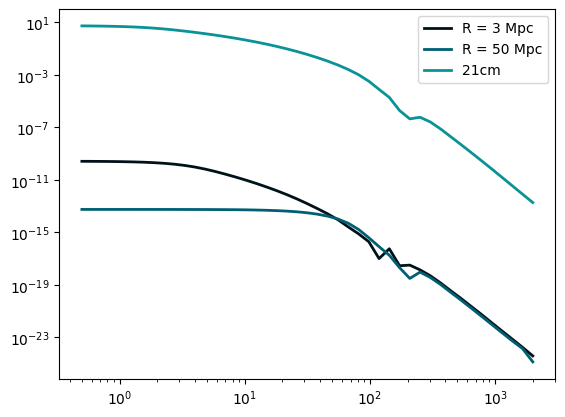

In [20]:
plt.loglog(PSLIM._rs_input_mcfit, PSLIM._deltaxi_LIM[0,:], label = 'R = %g Mpc'%LineParams_1._R)
plt.loglog(PSLIM_50._rs_input_mcfit, PSLIM_50._deltaxi_LIM[0,:], label = 'R = %g Mpc'%LineParams_50._R)
plt.loglog(PS21._rs_input_mcfit, PS21._II_deltaxi_xa[0,:], label = '21cm')
plt.legend()

Finally, we define the linear power spectrum as

$P_{\rm LIM}^{\rm lin}(k,z) = \tilde{W}_{R_O}^{\rm LIM}(k,z)^2 P_m^{\rm lin}(k)$ 

$(\Delta_{\rm LIM}^{\rm lin})^2 = \dfrac{k^3}{2\pi^2}P_{\rm LIM}^{\rm lin}$

and we add the non linear corrections if needed through

$\Delta_{\rm LIM}^2 = (\Delta_{\rm LIM}^{\rm lin})^2 + \dfrac{k^3}{2\pi^2}{\rm FT}(\delta_{x_i}^{\rm LIM})$


(1e-08, 100.0)

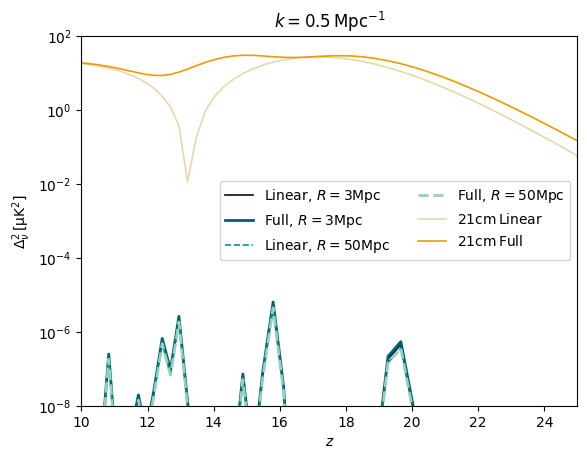

In [21]:
#choose a k to plot
klist = PSLIM.klist_PS
klist_21 = PS21.klist_PS
kchoose=0.5;
_ik = min(range(len(klist)), key=lambda i: np.abs(klist[i]-kchoose))
#_ik_05 = min(range(len(klist_05)), key=lambda i: np.abs(klist_05[i]-kchoose))
_ik_21 = min(range(len(klist_21)), key=lambda i: np.abs(klist_21[i]-kchoose))

plt.title(r'$k = %g\,{\rm Mpc^{-1}}$'%kchoose)
plt.semilogy(zlist,PSLIM.Deltasq_LIM_lin[:,_ik],'-', linewidth=1.2, label=r'$\rm Linear$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_1._R, )
plt.semilogy(zlist,PSLIM.Deltasq_LIM[:,_ik],'-' , label = r'$\rm Full$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_1._R,)

plt.semilogy(zlist,PSLIM_50.Deltasq_LIM_lin[:,_ik],'--', linewidth=1.2, label=r'$\rm Linear$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_50._R )
plt.semilogy(zlist,PSLIM_50.Deltasq_LIM[:,_ik],'--' , label=r'$\rm Full$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_50._R )

plt.semilogy(zlist,PS21.Deltasq_T21_lin[:,_ik],'-', linewidth=1.2, label=r'$\rm 21cm\, Linear$'  )
plt.semilogy(zlist,PS21.Deltasq_T21[:,_ik],'-', linewidth=1.2, label=r'$\rm 21cm\, Full$'  )

plt.xlabel(r'$z$');
plt.ylabel(r'$\Delta^2_{\nu}\,\rm[\mu {\rm K}^2]$');
plt.legend(ncol=2)

plt.xlim([10, 25])
plt.ylim([1e-8,1e2])

(0.01, 1)

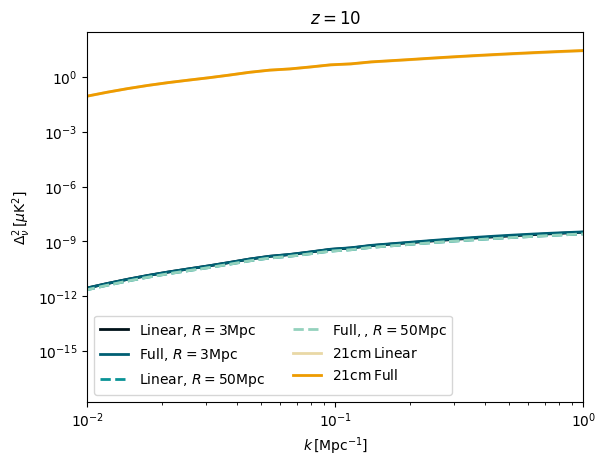

In [22]:
#choose a z to plot
zchoose=10.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

plt.title(r'$z = %g$'%zchoose)
plt.loglog(klist,PSLIM.Deltasq_LIM_lin[_iz], '-', label=r'$\rm Linear$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_1._R)
plt.loglog(klist,PSLIM.Deltasq_LIM[_iz], '-', label=r'$\rm Full$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_1._R)
plt.loglog(klist,PSLIM_50.Deltasq_LIM_lin[_iz], '--', label=r'$\rm Linear$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_50._R)
plt.loglog(klist,PSLIM_50.Deltasq_LIM[_iz], '--', label=r'$\rm Full,$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_50._R)
plt.loglog(klist,PS21.Deltasq_T21_lin[_iz], '-', label=r'$\rm 21cm\,Linear$')
plt.loglog(klist,PS21.Deltasq_T21[_iz], '-', label=r'$\rm 21cm\,Full$')

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{\nu}\,[\mu{\rm K}^2]$');
plt.legend(loc=3, ncol=2)

plt.xlim([1e-2,1])
#plt.ylim([1e-5,1e2])


We also compute the cross power spectrum between the matter density and LIM (and 21cm).

(0.01, 1)

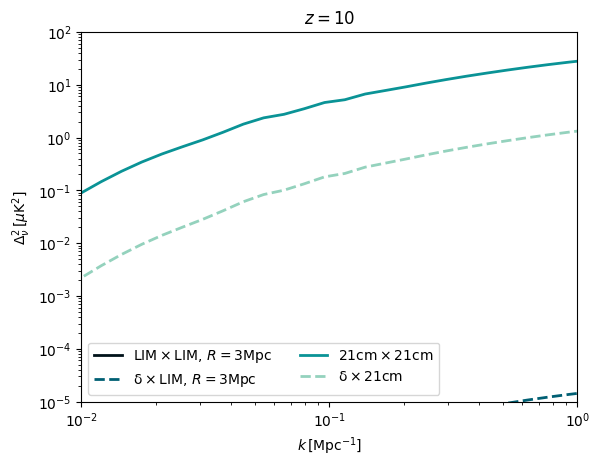

In [23]:
zchoose=10.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

plt.title(r'$z = %g$'%zchoose)
plt.loglog(klist,PSLIM.Deltasq_LIM[_iz], '-', label=r'$\rm LIM\times LIM$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_1._R)
plt.loglog(klist,PSLIM.Deltasq_dLIM[_iz], '--', label=r'$\rm \delta\times LIM$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_1._R)
plt.loglog(klist,PS21.Deltasq_T21[_iz], '-', label=r'$\rm 21cm \times 21cm$')
plt.loglog(klist,PS21.Deltasq_dT21[_iz], '--', label=r'$\rm \delta \times 21cm$')

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{\nu}\,[\mu{\rm K}^2]$');
plt.legend(loc=3, ncol=2)
plt.ylim([1e-5,1e2])

plt.xlim([1e-2,1])


Finally, we can produce map of the brightness temperature.

In the 21cm case, this is produced (using a lognormal distribution) by

1) define the $T_{21}^{\rm global}$ from the $T_{21}^{\rm avg}$ coefficients

2) interpolate $P_{21}^{\rm lin}(k)/(T_{21}^{\rm global})^2$

3) apply powerbox to get $\delta_{21}$

4) define the map through $T_{21}^{\rm global}(1+\delta_{21})$

In our case, we apply the same procedure using $\bar{I}_\nu$ instead of $T_{21}^{\rm global}$, since this is the observed quantity.

Cell size = 0.5 Mpc
R = 3 Mpc, Inu = 0.0 uK
             Mean map / Inu average = 1.0
R = 50 Mpc, Inu = 0.0 uK
             Mean map / Inu average = 1.0
T21_avg = 19.94 uK
             Mean map / T21 average = 1.0


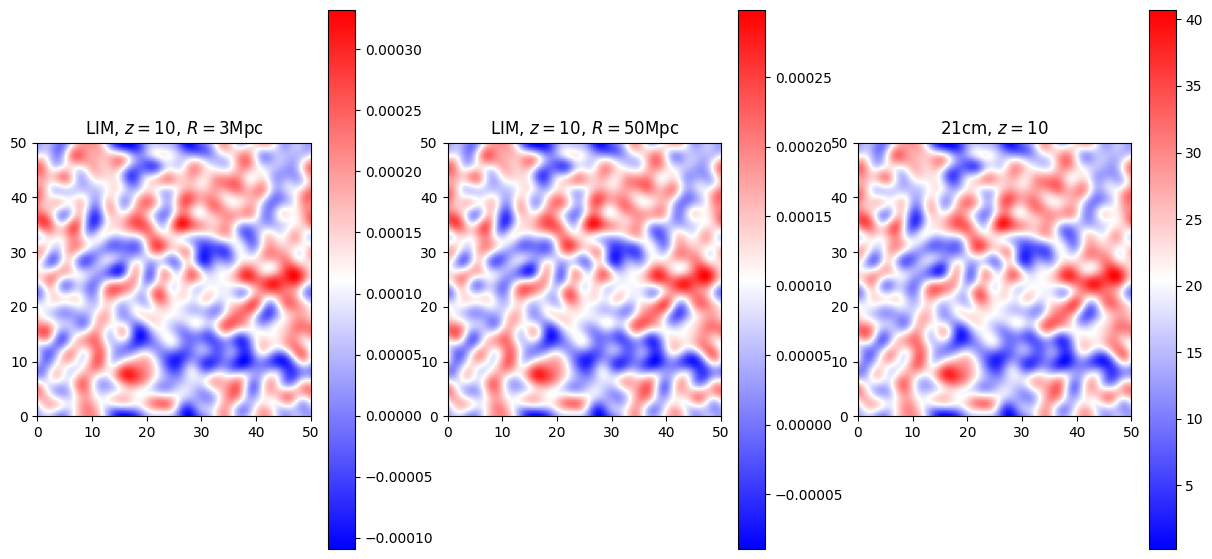

In [24]:
plt.figure(figsize=(15,7))
zval = 10.
Lbox = 50
Nbox = 100
Mapz = zeus21.CoevalMaps_LIM(CoeffStructure_1, PSLIM, PS21, zval, KIND=0, Lbox = Lbox, Nbox = Nbox)
Mapz_50 = zeus21.CoevalMaps_LIM(CoeffStructure_50, PSLIM_50, PS21, zval, KIND=0, Lbox = Lbox, Nbox = Nbox)
print('Cell size = ' + str(Lbox/Nbox) + ' Mpc')

_islice = 0
plt.subplot(131)
plt.imshow(Mapz.LIMmap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap='bwr') 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_1._R)
plt.colorbar()

print('R = 3 Mpc, Inu = ' + str(round(Mapz.Inu_global,2)) + ' uK')
print('             Mean map / Inu average = ' + str(round(np.mean(Mapz.LIMmap)/Mapz.Inu_global,2)) )#should have the correct mean


plt.subplot(132)
plt.imshow(Mapz_50.LIMmap[_islice],extent=(0,Mapz_50.Lbox,0,Mapz_50.Lbox),cmap='bwr') 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_50._R)
plt.colorbar()
print('R = 50 Mpc, Inu = ' + str(round(Mapz_50.Inu_global,2)) + ' uK')
print('             Mean map / Inu average = ' + str(round(np.mean(Mapz_50.LIMmap)/Mapz_50.Inu_global,2)) )#should have the correct mean


Mapz_21 = zeus21.CoevalMaps(CoeffStructure_21, PS21, zval, KIND=0, Lbox = Lbox, Nbox = Nbox)
_islice = 0
_islice = 0
plt.subplot(133)
plt.imshow(Mapz_21.T21map[_islice],extent=(0,Mapz_21.Lbox,0,Mapz_21.Lbox),cmap='bwr') 
plt.title(r'${\rm 21cm,\,}z = %g$'%zval )
plt.colorbar()
print('T21_avg = ' + str(round(Mapz_21.T21global,2)) + ' uK')
print('             Mean map / T21 average = ' + str(round(np.mean(Mapz_21.T21map)/Mapz_21.T21global,2))) #should have the correct mean

plt.show()

Cell size = 0.5 Mpc


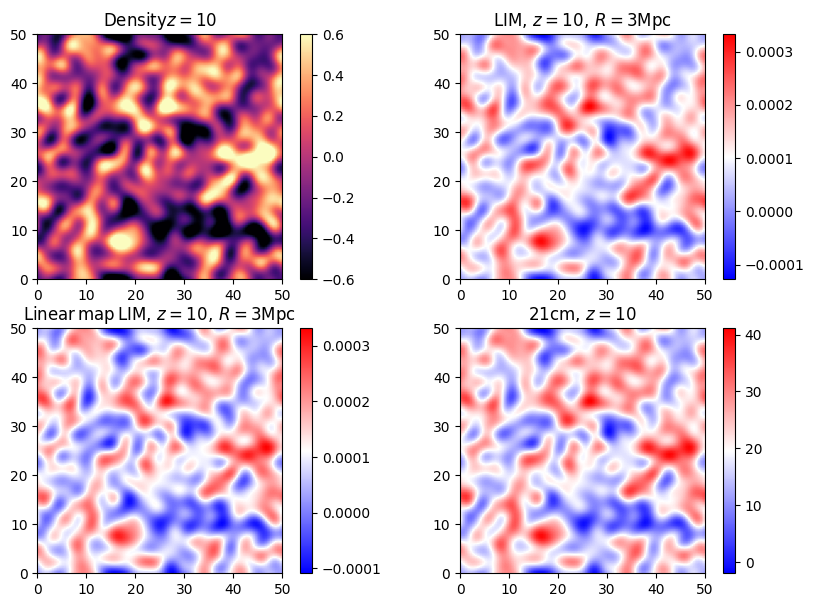

In [25]:
plt.figure(figsize=(10,7))
zval = 10.
Lbox = 50
Nbox = 100
Mapz = zeus21.CoevalMaps_LIM(CoeffStructure_1, PSLIM, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)
Mapz_21 = zeus21.CoevalMaps(CoeffStructure_21, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)
print('Cell size = ' + str(Lbox/Nbox) + ' Mpc')

_islice = 0

plt.subplot(221)
plt.imshow(Mapz.deltamap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap='magma',vmin=-0.6,vmax=0.6)
plt.title(r'${\rm Density}z = %g\,$'%zval )
plt.colorbar()


plt.subplot(222)
plt.imshow(Mapz.LIMmap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap='bwr') 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_1._R)
plt.colorbar()

plt.subplot(223)
plt.imshow(Mapz.LIMmap_lin[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap='bwr') 
plt.title(r'${\rm Linear\,map\,LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_1._R)
plt.colorbar()

plt.subplot(224)
plt.imshow(Mapz_21.T21map[_islice],extent=(0,Mapz_21.Lbox,0,Mapz_21.Lbox),cmap='bwr') 
plt.title(r'${\rm 21cm,\,}z = %g$'%zval )
plt.colorbar()

plt.show()

(0.001, 30.0)

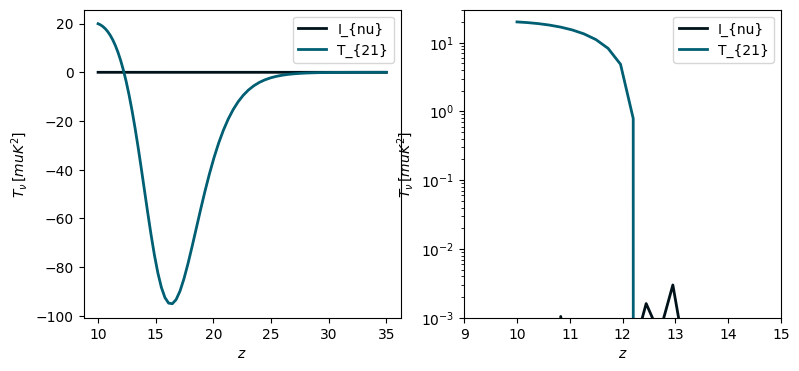

In [26]:
plt.figure(figsize=(9,4))

plt.subplot(121)
plt.plot(CoeffStructure_1.zintegral,CoeffStructure_1.Inu_avg,label='I_{nu}')
plt.plot(CoeffStructure_21.zintegral,CoeffStructure_21.T21avg,label='T_{21}')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$T_{\nu} \,[muK^2]$')

plt.subplot(122)
plt.semilogy(CoeffStructure_1.zintegral,CoeffStructure_1.Inu_avg,label='I_{nu}')
plt.semilogy(CoeffStructure_21.zintegral,CoeffStructure_21.T21avg,label='T_{21}')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$T_{\nu} \,[muK^2]$')
plt.xlim(9,15)
plt.ylim(1e-3,3e1)